# Statistical Algos

## Notebook's Environment

In [1]:
INSTALL_DEPS = False
if INSTALL_DEPS:
  %pip install matplotlib==3.8.3
  %pip installnumpy==1.26.4
  %pip installpandas==2.2.1
  %pip installpandas_market_calendars==4.4.0
  %pip installpytz==2024.1
  %pip installscipy==1.12.0
  %pip installta==0.11.0
  %pip installyfinance==0.2.37

!python --version

Python 3.11.8


## Cloud Environment Setup

In [2]:
import os
import sys
import warnings

warnings.filterwarnings("ignore")

IN_KAGGLE = IN_COLAB = False
try:
    # https://www.tensorflow.org/install/pip#windows-wsl2
    import google.colab
    from google.colab import drive

    drive.mount("/content/drive")
    DATA_PATH = "/content/drive/MyDrive/EDT dataset"
    MODEL_PATH = "/content/drive/MyDrive/models"
    IN_COLAB = True
    print("Colab!")
except:
    IN_COLAB = False
if "KAGGLE_KERNEL_RUN_TYPE" in os.environ and not IN_COLAB:
    print("Running in Kaggle...")
    for dirname, _, filenames in os.walk("/kaggle/input"):
        for filename in filenames:
            print(os.path.join(dirname, filename))
    MODEL_PATH = "./models"
    DATA_PATH = "/kaggle/input/"
    IN_KAGGLE = True
    print("Kaggle!")
elif not IN_COLAB:
    IN_KAGGLE = False
    MODEL_PATH = "./models"
    DATA_PATH = "./data/"
    print("running localhost!")

running localhost!


# Instruments

In [3]:
class YFinanceOptions:
    INDEX = "Datetime"
    MIN1_RANGE = 7 - 1
    MIN15_RANGE = 60 - 1
    HOUR_RANGE = 730 - 1
    DAY_RANGE = 7300 - 1
    D1="1d"
    H1="1h"
    M15="15m"
    M1="1m"
    DATE_TIME_FORMAT = "%Y-%m-%d"
    DATE_TIME_HRS_FORMAT = '%Y-%m-%d %H:%M:%S %Z'

INTERVAL = YFinanceOptions.M15

# Metals
GOLD_FUT = "GC=F"
SILVER_FUT = "SI=F"
COPPER_FUT = "HG=F"
PLATINUM_FUT = "PL=F"
PALLADIUM_FUT = "PA=F"

METALS_FUTS = [GOLD_FUT, SILVER_FUT, COPPER_FUT, PLATINUM_FUT, PALLADIUM_FUT]

# Energy
CRUDEOIL_FUT = "CL=F"
NATURALGAS_FUT = "NG=F"
HEATINGOIL_FUT = "HO=F"
RBOB_FUT = "RB=F"


ENERGY_FUTS = [CRUDEOIL_FUT, NATURALGAS_FUT, HEATINGOIL_FUT, RBOB_FUT]

# Agri
CORN_FUT = "ZC=F"
SOYOIL_FUT = "ZL=F"
KCWHEAT_FUT = "KE=F"
SOYBEAN_FUT = "ZS=F"
SOYBEANMEAL_FUT = "ZM=F"
WHEAT_FUT = "ZW=F"
LIVECATTLE_FUT = "LE=F"
LEANHOG_FUT = "HE=F"
FEEDERCATTLE_FUT = "GF=F"
MILK_FUT = "DC=F"

AGRI_FUTS = [CORN_FUT, SOYOIL_FUT, KCWHEAT_FUT, SOYBEAN_FUT, SOYBEANMEAL_FUT, WHEAT_FUT, LIVECATTLE_FUT, LEANHOG_FUT, FEEDERCATTLE_FUT, MILK_FUT]

FUTS = AGRI_FUTS + METALS_FUTS + ENERGY_FUTS

TARGET_FUT=KCWHEAT_FUT.replace("=F", "")

## Data Load

In [4]:
import pandas as pd
import numpy as np

filename = f"{DATA_PATH}{os.sep}futures_{INTERVAL}.csv"
print(filename)
futs_df = pd.read_csv(filename, index_col="Date", parse_dates=True)

print(futs_df.shape)
print(futs_df.columns)
futs_df.head(2)

./data/\futures_15m.csv
(4224, 144)
Index(['2YY_Open', '2YY_High', '2YY_Low', '2YY_Close', '2YY_Volume',
       '2YY_Spread', 'CL_Open', 'CL_High', 'CL_Low', 'CL_Close',
       ...
       'ZW_Low', 'ZW_Close', 'ZW_Volume', 'ZW_Spread', '^VIX_Open',
       '^VIX_High', '^VIX_Low', '^VIX_Close', '^VIX_Volume', '^VIX_Spread'],
      dtype='object', length=144)


,2YY_Open,2YY_High,2YY_Low,2YY_Close,2YY_Volume,2YY_Spread,CL_Open,CL_High,CL_Low,CL_Close,...,ZW_Low,ZW_Close,ZW_Volume,ZW_Spread,^VIX_Open,^VIX_High,^VIX_Low,^VIX_Close,^VIX_Volume,^VIX_Spread
Date,,,,,,,,,,,,,,,,,,,,,
2024-03-17 22:16:00+00:00,4.662,4.662,4.662,4.662,1,0.0,81.769997,81.769997,81.290001,81.419998,...,535.0,535.75,7123,3.75,14.75,14.81,14.73,14.81,0,0.080001
2024-03-17 22:31:00+00:00,4.662,4.662,4.662,4.662,1,0.0,81.769997,81.769997,81.290001,81.419998,...,535.0,535.75,7123,3.75,14.75,14.81,14.73,14.81,0,0.080001


# Problem Defintion

Utilize meduim-frequency trade data for a set of 6 Future contracts listed on CME during a 250-day trading periods between 01/01/2023 and 01/01/2024. Future contracts are cross-sectional from metals, equities and volatiliyy. Trading is 23hours, with minute durations.

## Intra-Day Mean Reversion

https://learning.oreilly.com/library/view/algorithmic-trading-winning/9781118746912/OEBPS/9781118746912_epub_c02.htm#c02-sec1-0001

Using Augmented Dickey-Fuller (ADF) for stationarity:

$\Delta y(t) = \alpha + \beta t + \gamma y(t-1) + \delta_1 \Delta y(t-1) + \cdots + \delta_{p-1} \Delta y(t-p+1) + \epsilon_t$

where:
- $\Delta y(t) = y(t) - y(t-1)$ represents the first difference of the series.
- $y(t-1)$ is the lagged value of the series.
- $\beta t$, often set to zero in price series analyses, accounts for any deterministic time trend.
- $\delta_1, \delta_2, ..., \delta_{p-1}$ are coefficients for the lagged differences, adjusting for serial correlation.
- $\epsilon_t$ is the error term.


The null hypothesis $H_0: \gamma = 0$ suggests the presence of a unit root, indicating non-stationarity if the test statistic is $< 0.5$.

$\text{Test Statistic} = \frac{\hat{\gamma}}{\text{SE}(\hat{\gamma})}$

where $\text{SE}(\hat{\gamma})$ is the standard error of $\hat{\gamma}$. 

Given a significance of $\alpha=0.05$, having critical values of $-2.86 \text{ to} -3.45$.
- $\text{SE} < 0 $ and $ p < 0.05 = \text{Mean reverting}$
- $\text{SE} > 0 $ and $ p < 0.05 = \text{Trending}$

From our EDA:
| Series     | Lag | Coefficient | P-Value          |
|------------|-----|-------------|------------------|
| NQ_Close   | 1   | 0.999967    | 0.000000e+00     |
| NQ_Close   | 5   | -0.017068   | 8.802106e-30     |

A the 5 min lag, the series shows a **weak** mean-reversion $-0.017068 > -2.86$.
At the 1 min lag it trends, the AR is strong towards the direction.

### Mean Reversion Probability

In [5]:
nq_fut_df = futs_df[[f"{TARGET_FUT}_Close"]].copy()
nq_fut_df.index = pd.to_datetime(nq_fut_df.index)
nq_fut_df.sort_index(inplace=True)

nq_fut_df.head(2)

,KE_Close
Date,
2024-03-17 22:16:00+00:00,568.0
2024-03-17 22:31:00+00:00,568.0


### Ornstein-Uhlenbeck (OU) 

Typically, a Hurst exponent significantly different from 0.5 indicates long-term memory (H > 0.5) or anti-persistent behavior (H < 0.5).



In [6]:
from statsmodels.tsa.stattools import adfuller
from statsmodels.regression.linear_model import OLS
from statsmodels.tools.tools import add_constant
import statsmodels.api as sm
from hurst import compute_Hc

NOISE_THRESHOLD = 5.
LAGS_IN_MINS =  [1]

def get_ou(df, col):
    log_prices = np.log(df[col])

    h, _, _ = compute_Hc(log_prices, kind='price', simplified=True)
    spread_lag = log_prices.shift(1).bfill()

    spread_ret = (log_prices - spread_lag).bfill()
    spread_lag2 = sm.add_constant(spread_lag)

    model = sm.OLS(spread_ret, spread_lag2)
    res = model.fit()
    hl = int(round(-np.log(2) / res.params[1], 0))

    return hl, h

HALF_LIFE, HURST = get_ou(nq_fut_df, f"{TARGET_FUT}_Close")

print("Half-Life:", HALF_LIFE)
print("Hurst:", HURST)

Half-Life: 563
Hurst: 0.5016842133837789


The variance ratio (VR) test is used to determine if a time series follows a random walk and its scaling. The variance ratio is defined as:

`z(t)` is the value of the time series at time \( t \).  
`z(t-\tau)` is the value of the time series at time \( t - \tau \), where \( \tau \) is a lag.  
`Var(x)` denotes the variance of the variable \( x \).

The formula is:

$$
\frac{\text{Var}(z(t) - z(t-\tau))}{\tau \, \text{Var}(z(t) - z(t-1))}
$$

- VR≈1: Consistent with a random walk.
- VR>1: Indicates positive serial correlation (momentum).
- VR<1: Indicates negative serial correlation (mean reversion).

and test statistics:
- Is heteroskedasticity (variance changing over time).
- Is autocorrelation (returns at different times being correlated).

In [7]:
from scipy.stats import norm

def var_ratio(df, col, k=100):
    # https://mingze-gao.com/posts/lomackinlay1988/#source-code
    log_prices = np.log(df[col])

    rets = np.diff(log_prices)
    T = len(rets)
    mu = np.mean(rets)
    var_1 = np.var(rets, ddof=1, dtype=np.float64)
    rets_k = (log_prices - np.roll(log_prices, k))[k:]
    m = k * (T - k + 1) * (1 - k / T)
    var_k = 1/m * np.sum(np.square(rets_k - k * mu))

    # Variance Ratio
    vr = var_k / var_1
    # Phi1
    phi1 = 2 * (2*k - 1) * (k-1) / (3*k*T)
    # Phi2

    def delta(j):
        res = 0
        for t in range(j+1, T+1):
            t -= 1  # array index is t-1 for t-th element
            res += np.square((rets[t]-mu)*(rets[t-j]-mu))
        return res / ((T-1) * var_1)**2

    phi2 = 0
    for j in range(1, k, 2):
        phi2 += (2*(k-j)/k)**2 * delta(j)

    # Test statistics
    ts1 = (vr - 1) / np.sqrt(phi1)
    ts2 = (vr - 1) / np.sqrt(phi2)

    # P-values
    p_value1 = 2 * (1 - norm.cdf(np.abs(ts1)))  # two-tailed
    p_value2 = 2 * (1 - norm.cdf(np.abs(ts2)))

    return vr, ts1, p_value1, ts2, p_value2

vr, ts1, p_value1, ts2, p_value2 = var_ratio(nq_fut_df, f"{TARGET_FUT}_Close")
print(f"Variance Ratio: {vr}")
print(f"Test Statistic 1: {ts1} at P-Value 1: {p_value1:.12f}")
print(f"Test Statistic 2: {ts2} at P-Value 2: {p_value2:.12f}")

Variance Ratio: 0.3842009072355591
Test Statistic 1: -3.4918138197367488 at P-Value 1: 0.000479752525
Test Statistic 2: -3.578077805657374 at P-Value 2: 0.000346130424


## Probabilities of Reversion

In [8]:
for lag in LAGS_IN_MINS:
    trend_col = f'T_{lag}M'
    mr_col = f'MR_{lag}M'

    nq_fut_df[trend_col] = nq_fut_df[f'{TARGET_FUT}_Close'].diff(lag).bfill()
    nq_fut_df[trend_col] = nq_fut_df[trend_col].apply(lambda x: np.sign(x))

    nq_fut_df[mr_col] = (nq_fut_df[trend_col] != nq_fut_df[trend_col].shift(lag).bfill()).astype(int)

nq_fut_df.head(5)

,KE_Close,T_1M,MR_1M
Date,,,
2024-03-17 22:16:00+00:00,568.0,0.0,0
2024-03-17 22:31:00+00:00,568.0,0.0,0
2024-03-17 22:46:00+00:00,568.0,0.0,0
2024-03-17 23:01:00+00:00,568.0,0.0,0
2024-03-17 23:16:00+00:00,568.0,0.0,0


In [9]:
mr_proba = {}
for col in nq_fut_df.columns:
    if col.startswith('MR_'):
        mr_proba[col] = nq_fut_df[col].mean()

probabilities_df = pd.DataFrame(list(mr_proba.items()), columns=['Lag', 'Probability'])
probabilities_df['Lag'] = probabilities_df['Lag'].str.extract('(\d+)').astype(int)
probabilities_df.sort_values('Lag', inplace=True)
probabilities_df

,Lag,Probability
0,1,0.50947


In [10]:
MAX_TRENDS = 15
revert_proba = {}
for lag in LAGS_IN_MINS:
    trend_reversion_prob = {}
    trend_col = f'T_{lag}M'
    mr_col = f'MR_{lag}M'

    for x in range(0, MAX_TRENDS + 1):
        rolling_trends = nq_fut_df[trend_col].rolling(window=x).sum() == x
        still_trending = rolling_trends.shift(1)

        reverted = nq_fut_df[mr_col]
        reverting_after_trends = (reverted & still_trending)
        total_trends = still_trending.sum()

        if total_trends > 0:
            trend_reversion_prob[x] = reverting_after_trends.sum() / total_trends

    revert_proba[lag] = trend_reversion_prob

assert len(revert_proba) > 0

rows = []
for lag, probs in revert_proba.items():
    for trend, probability in probs.items():
        rows.append({'Lag': lag, 'Trends': trend, 'Probability': probability})

temp_df = pd.DataFrame(rows)
pivot_df = temp_df.pivot(index='Trends', columns='Lag', values='Probability')
pivot_df = pivot_df.reindex(sorted(pivot_df.columns, key=int), axis=1)
pivot_df.T

Trends,0,1,2,3,4,5,6,7,8
Lag,,,,,,,,,
1,0.50959,0.614431,0.621928,0.62,0.578947,0.53125,0.666667,0.8,1.0


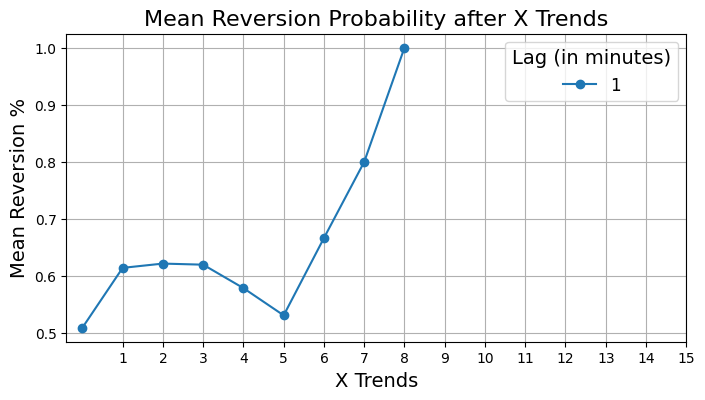

In [11]:
import matplotlib.pyplot as plt

pivot_df.plot(kind='line', marker='o', figsize=(8, 4))

plt.title('Mean Reversion Probability after X Trends', fontsize=16)
plt.xlabel('X Trends', fontsize=14)
plt.ylabel('Mean Reversion %', fontsize=14)
plt.legend(title='Lag (in minutes)', fontsize=12, title_fontsize=14)
plt.grid(True)
plt.xticks(range(1, MAX_TRENDS + 1))
plt.show()

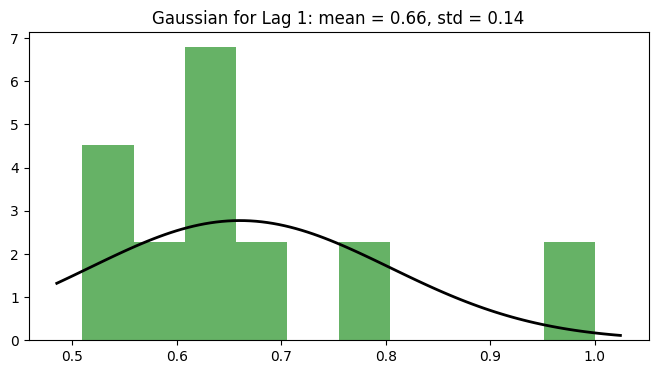

,Lag,Mean,Std
0,1,0.660313,0.143813


In [12]:
from scipy.stats import norm

distribution_params = pd.DataFrame(columns=['Lag', 'Mean', 'Std'])
for lag in pivot_df.columns:
    data = pivot_df[lag].dropna()
    if not data.empty:
        mu, std = norm.fit(data)
        new_row = pd.DataFrame({
            'Lag': [lag],
            'Mean': [mu],
            'Std': [std]
        })
        distribution_params = pd.concat([distribution_params, new_row], ignore_index=True)

        plt.figure(figsize=(8, 4))
        plt.hist(data, bins=10, density=True, alpha=0.6, color='g')
        xmin, xmax = plt.xlim()
        x = np.linspace(xmin, xmax, 100)
        p = norm.pdf(x, mu, std)
        plt.plot(x, p, 'k', linewidth=2)
        plt.title(f"Gaussian for Lag {lag}: mean = {mu:.2f}, std = {std:.2f}")
        plt.show()

distribution_params

# Bollinger Bands

In [13]:
from tqdm import tqdm
import itertools
import math

def calculate_std_factor(hurst, base_std=2.0, adjustment=0.5):
    if hurst < 0.5:
        # Reverting, increase this band
        return base_std + (0.5 - hurst) * adjustment
    elif hurst > 0.5:
        # Trending, decrease band
        return base_std - (hurst - 0.5) * adjustment
    else:
        return base_std

def kalman_filter_step(price, m_prev, R_prev, delta, ve):
    m_pred = m_prev
    R_pred = R_prev + delta

    K = R_pred / (R_pred + ve)
    m_curr = m_pred + K * (price - m_pred)
    R_curr = (1 - K) * R_pred

    return m_curr, R_curr

def bollinger_band_backtest(df, target_col, window, std_factor, delta=1e-3, ve=1e-2):
    n = len(df)
    m = np.zeros(n)
    R = np.zeros(n)

    initial_prices = df[target_col].values[:window]
    m[:window] = initial_prices.mean()
    R[:window] = initial_prices.var()
    for t in range(window, n):
        m[t], R[t] = kalman_filter_step(df[target_col].values[t], m[t-1], R[t-1], delta, ve)

    df['MA'] = m
    df['SD'] = np.sqrt(R)

    df['U'] = df['MA'] + (df['SD'] * std_factor)
    df['L'] = df['MA'] - (df['SD'] * std_factor)

    df['SB'] = (df[target_col] < df['L']).astype(int).diff().clip(0) * +1
    df['SS'] = (df[target_col] > df['U']).astype(int).diff().clip(0) * -1
    df['SBS'] = (df[target_col] > df['MA']).astype(int).diff().clip(0) * -1
    df['SSB'] = (df[target_col] < df['MA']).astype(int).diff().clip(0) * +1

    df['Closed'] = 0
    df['Position'] = 0
    df['Ret'] = 0.
    entry = position = 0

    for i, row in df.iterrows():
        if (row['SBS'] == -1 and position == 1) or (row['SSB'] == 1 and position == -1):
            if position == 1:
                df.loc[i, 'Ret'] = (row[target_col] - entry) / entry
                df.loc[i, 'Closed'] = 1
            else:
                df.loc[i, 'Ret'] = (entry - row[target_col]) / entry
                df.loc[i, 'Closed'] = -1
            position = 0

        if (row['SB'] == 1 and position == 0) or (row['SS'] == -1 and position == 0):
            entry = row[target_col]
            position = 1 if row['SB'] == 1 else -1
        df.loc[i, 'Position'] = position

    df['cRets'] = (1 + df['Ret']).cumprod() - 1

    variance = df['Ret'].var()
    df['Drawdown'] = (1 + df['Ret']).cumprod().div((1 + df['Ret']).cumprod().cummax()) - 1
    max_drawdown = df['Drawdown'].min()
    drawdown_length = (df['Drawdown'] < 0).astype(int).groupby(df['Drawdown'].eq(0).cumsum()).cumsum().max()
    negative_returns = df['Ret'][df['Ret'] < 0]
    sortino_ratio = df['Ret'].mean() / negative_returns.std() * np.sqrt(24192)  # 60/15 * 24 * 252 Intervals
    trades = (df['Position'].diff().ne(0) & df['Position'].ne(0)).sum()

    stats_df = pd.DataFrame({
        "Window": [window],
        "Standard_Factor": [std_factor],
        "Cumulative_Returns": [df['cRets'].iloc[-1]],
        "Max Ret": [df['Ret'].max()],
        "Max Loss": [df['Ret'].min()],
        "Variance": [variance],
        "STD": [np.sqrt(variance)],
        "Max_Drawdown": [max_drawdown],
        "Drawdown_Length": [drawdown_length],
        "Sortino_Ratio": [sortino_ratio],
        "Trades_Count": [trades],
        "Trades_per_Interval": [trades / len(df)],
        "Trading_Intervals": [len(df)],
    })

    return df, stats_df

def param_search_bbs(df, target_col, initial_window=HALF_LIFE, window_factor = 1.5, window_min = 4, intial_std_adjustment=0.5, hurst=HURST):
    assert initial_window > window_min

    num_steps = int(math.log(initial_window / window_min, window_factor)) + 1
    windows = [int(initial_window // (window_factor**i)) for i in range(num_steps)]
    std_adjustments = [intial_std_adjustment/2, intial_std_adjustment, intial_std_adjustment * 1.5, intial_std_adjustment * 2]
    combinations = list(itertools.product(windows, std_adjustments))

    best_sortino = -float('inf')
    best_sortino_stats = None
    best_rets = -float('inf')
    best_rets_stats = None
    best_mdd = -float('inf')
    best_mdd_stats = None

    for window, adjustment in tqdm(combinations, desc="param_search_bbs"):
        std_factor = calculate_std_factor(hurst, intial_std_adjustment, adjustment)
        _, stats_df = bollinger_band_backtest(df, target_col, window,std_factor)

        stat = stats_df['Sortino_Ratio'].iloc[0]
        if stat > best_sortino:
            best_sortino = stat
            best_sortino_stats = stats_df

        stat = stats_df['Cumulative_Returns'].iloc[0]
        if stat > best_rets:
            best_rets = stat
            best_rets_stats = stats_df

        stat = stats_df['Max_Drawdown'].iloc[0]
        if stat > best_mdd:
            best_mdd = stat
            best_mdd_stats = stats_df

    results_df = pd.concat([best_sortino_stats.assign(Metric='Sortino'),
                            best_rets_stats.assign(Metric='Cumulative Returns'),
                            best_mdd_stats.assign(Metric='Max Drawdown')],
                           ignore_index=True)

    return results_df


stats_df = param_search_bbs(futs_df, f'{TARGET_FUT}_Close', initial_window=HALF_LIFE, hurst=HURST)
cumret_df= stats_df[stats_df["Metric"] == "Cumulative Returns"]
BEST_WINDOW = cumret_df["Window"].values[0]
BEST_STD_FACTOR = cumret_df["Standard_Factor"].values[0]

stats_df

param_search_bbs: 100%|██████████| 52/52 [00:35<00:00,  1.45it/s]


,Window,Standard_Factor,Cumulative_Returns,Max Ret,Max Loss,Variance,STD,Max_Drawdown,Drawdown_Length,Sortino_Ratio,Trades_Count,Trades_per_Interval,Trading_Intervals,Metric
0,49,0.499579,10.491902,0.027991,-0.057783,0.000009,0.002933,-0.078492,1140,12.345125,898,0.212595,4224,Sortino
1,250,0.499579,10.715069,0.027991,-0.057783,0.000009,0.002956,-0.078492,1140,12.247786,878,0.207860,4224,Cumulative Returns
2,111,0.499579,10.360357,0.027991,-0.057783,0.000009,0.002929,-0.078492,1140,12.259722,893,0.211411,4224,Max Drawdown


## Results

Cumulative returns from the strategy: 1071.51%


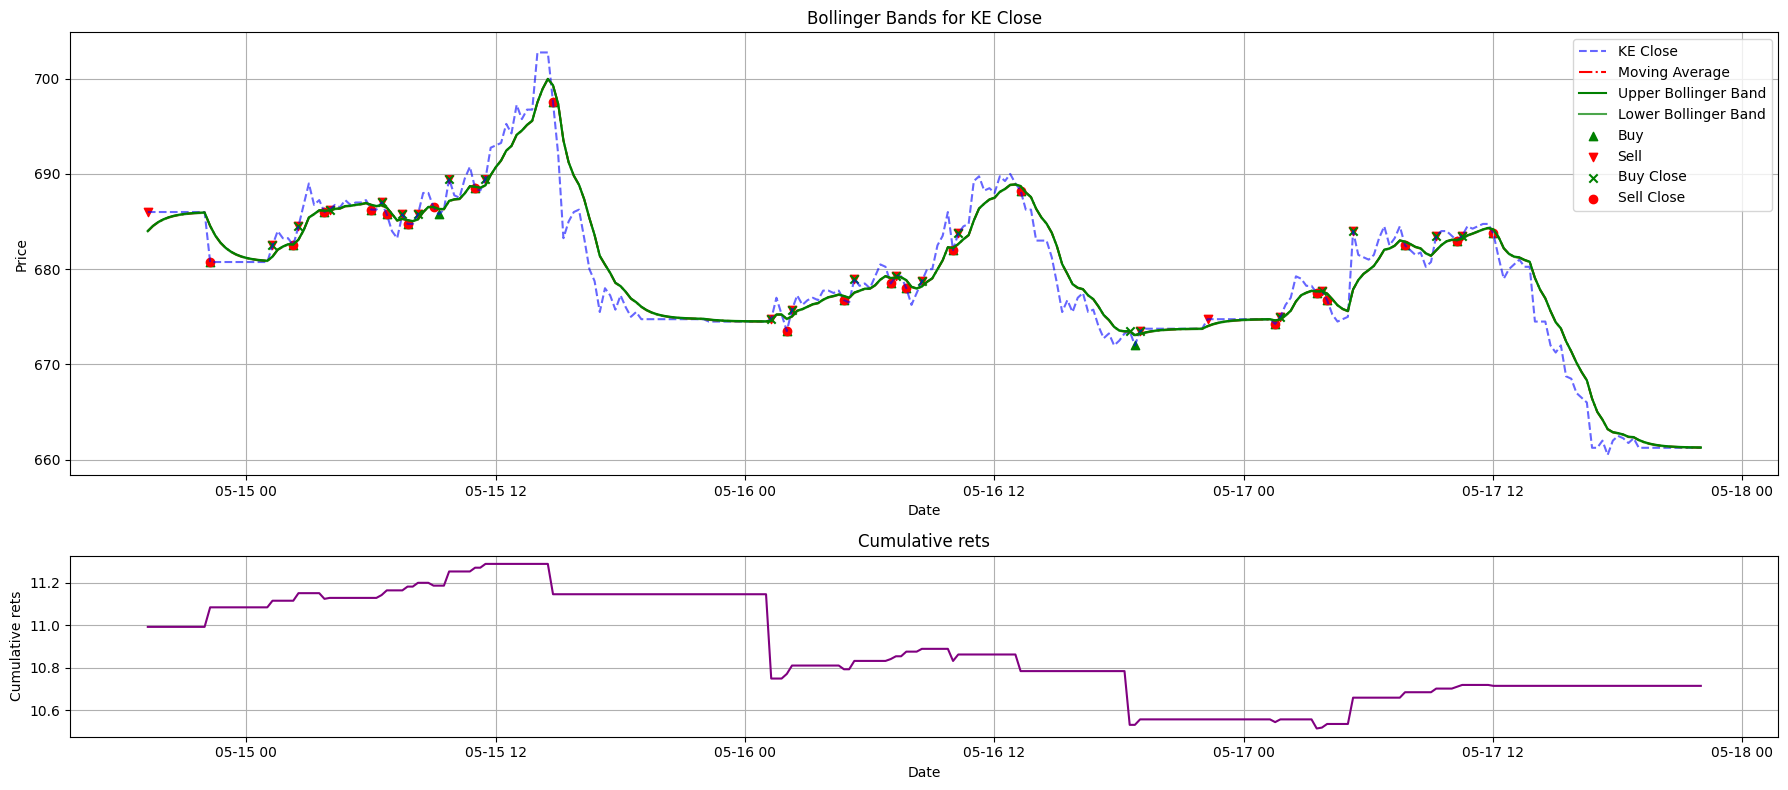

In [14]:
backtest_df = futs_df[[f'{TARGET_FUT}_Close']].copy()
backtest_df, stats_df = bollinger_band_backtest(backtest_df, f'{TARGET_FUT}_Close', BEST_WINDOW, BEST_STD_FACTOR)
backtest_df['cRets'] = (1 + backtest_df['Ret']).cumprod() - 1
print(f"Cumulative returns from the strategy: {backtest_df['cRets'].iloc[-1]*100.:.02f}%")

# Visualization should be easier
backtest_df = backtest_df.tail(300)

plt.figure(figsize=(18, 8))
buy_signals = backtest_df[backtest_df['SB'] > 0]
sell_signals = backtest_df[backtest_df['SS'] < 0]
long_closed = backtest_df[backtest_df['Closed'] > 0]
short_closed = backtest_df[backtest_df['Closed'] < 0]

ax1 = plt.subplot2grid((6, 1), (0, 0), rowspan=4, colspan=1)  # Main plot gets more space
ax1.plot(backtest_df[f'{TARGET_FUT}_Close'], label=f'{TARGET_FUT} Close', color='blue', alpha=0.6, linestyle='--')
ax1.plot(backtest_df['MA'], label='Moving Average', color='red', linestyle='-.')
ax1.plot(backtest_df['U'], label='Upper Bollinger Band', color='green')
ax1.plot(backtest_df['L'], label='Lower Bollinger Band', color='green', alpha=0.7)
ax1.scatter(buy_signals.index, buy_signals[f'{TARGET_FUT}_Close'], color='green', marker='^', label='Buy')
ax1.scatter(sell_signals.index, sell_signals[f'{TARGET_FUT}_Close'], color='red', marker='v', label='Sell')
ax1.scatter(long_closed.index, long_closed[f'{TARGET_FUT}_Close'], color='green', marker='x', label='Buy Close')
ax1.scatter(short_closed.index, short_closed[f'{TARGET_FUT}_Close'], color='red', marker='o', label='Sell Close')

ax1.set_title(f'Bollinger Bands for {TARGET_FUT} Close')
ax1.set_xlabel('Date')
ax1.set_ylabel('Price')
ax1.legend()
ax1.grid(True)

ax2 = plt.subplot2grid((6, 1), (4, 0), rowspan=2, colspan=1, sharex=ax1)
ax2.plot(backtest_df['cRets'], label='Cumulative rets', color='purple')
ax2.set_title('Cumulative rets')
ax2.set_xlabel('Date')
ax2.set_ylabel('Cumulative rets')
ax2.grid(True)

plt.tight_layout()
plt.show()

# Test all Futs

In [15]:
all_metrics = pd.DataFrame()
for fut in FUTS:
    target=fut.replace("=F", "")

    fut_df = futs_df[[f"{target}_Close"]].copy()
    hl, h = get_ou(fut_df, f"{target}_Close")
    stats_df = param_search_bbs(fut_df, f'{target}_Close', initial_window=hl, hurst=h)

    all_metrics = pd.concat([all_metrics, stats_df.assign(Fut=target, Hurst=h, Halflife=h)], ignore_index=True)

    mr_metrics = all_metrics[all_metrics.Hurst < 0.5]
    mr_metrics = mr_metrics.sort_values(by="Cumulative_Returns", ascending=False)
    mr_metrics[["Cumulative_Returns", "Window","Standard_Factor","Metric","Fut"]]

param_search_bbs: 100%|██████████| 80/80 [00:56<00:00,  1.40it/s]


AssertionError: 